[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mikey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mikey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Enter the start date (dd-mm-yyyy):  01-01-2019
Enter the end date (dd-mm-yyyy):  01-02-2019


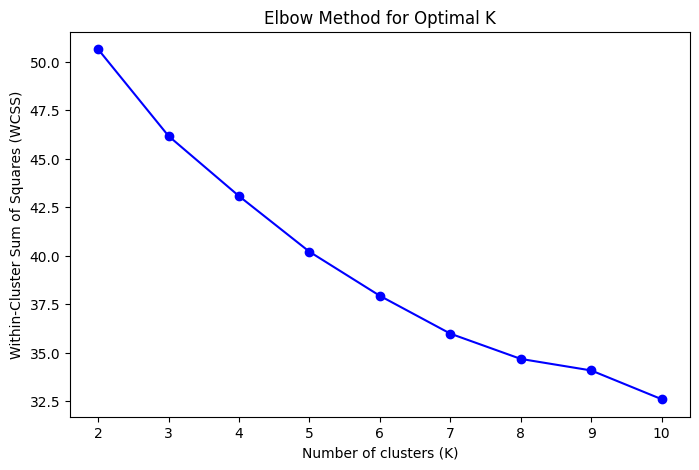

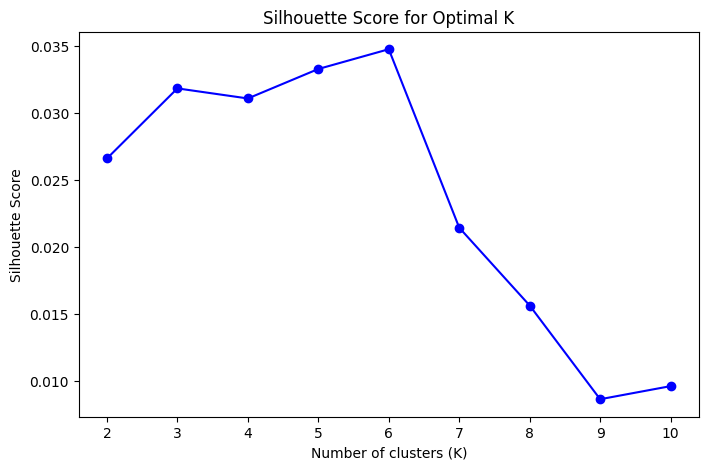

Best number of clusters (K) based on silhouette score: 6


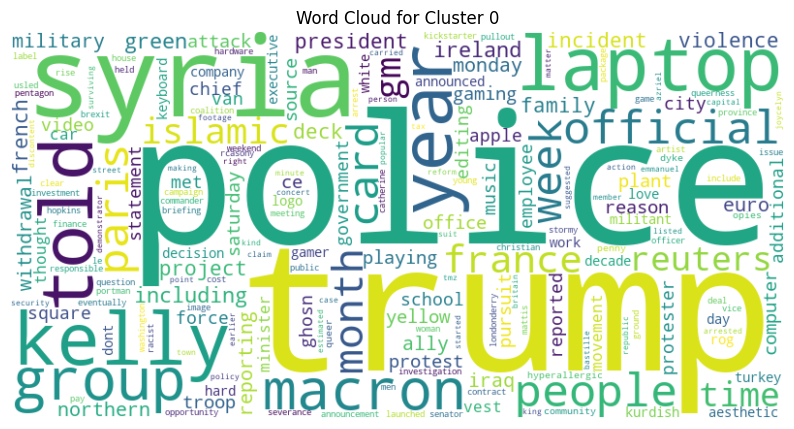

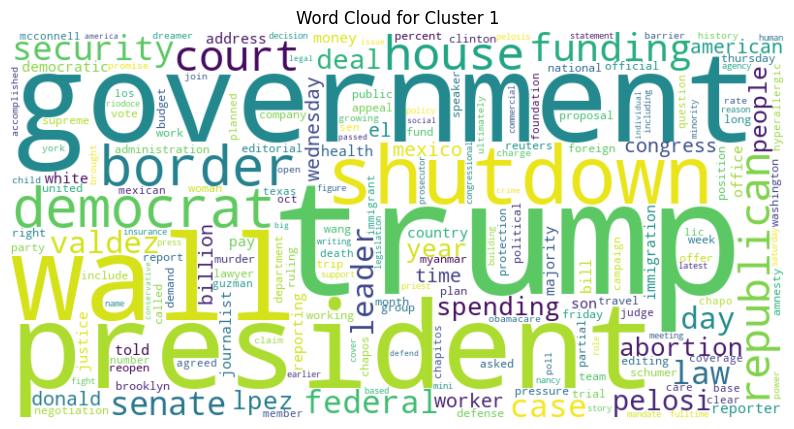

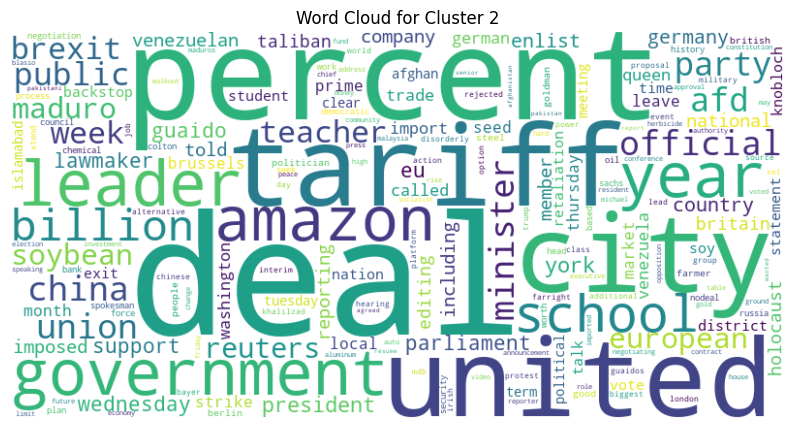

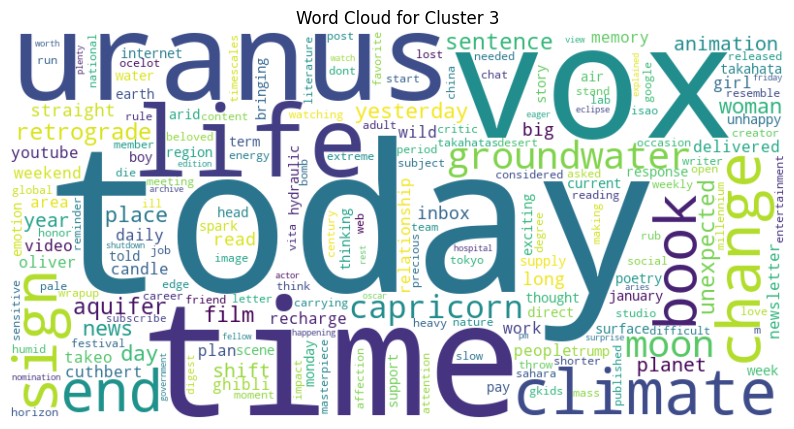

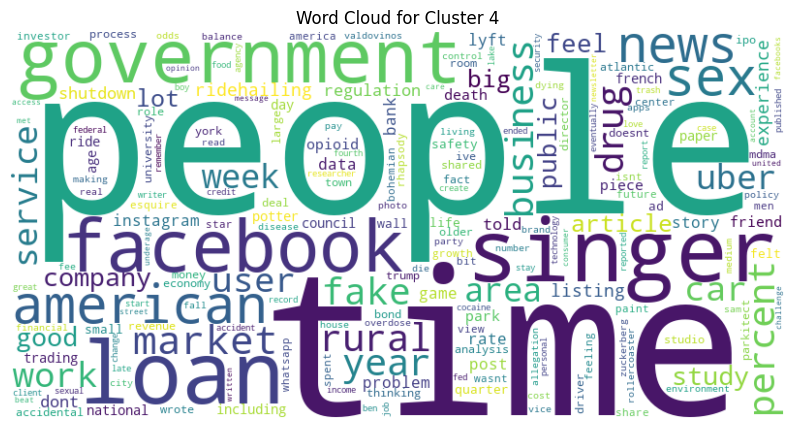

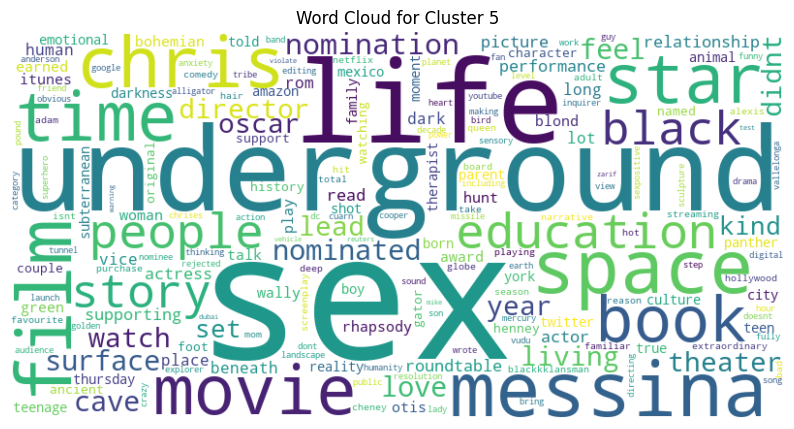

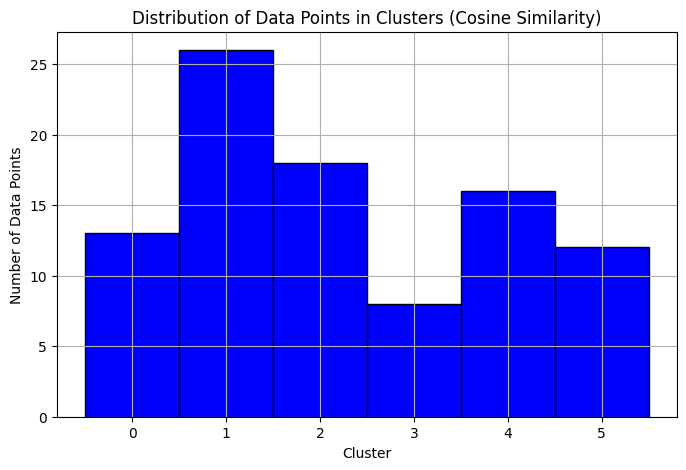

Silhouette Score (Cosine): 0.03474409278581416


In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
import nltk

nltk.download('punkt')
nltk.download('wordnet')

# Reading the csv file
df = pd.read_csv("cleanednewsarticles.csv")

# Convert the date column to datetime format (dd-mm-yyyy hh:mm)
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

# Function to filter articles by date range
def filter_by_date(df, start_date, end_date):
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    return df[mask]

# User input for date range
start_date = pd.to_datetime(input("Enter the start date (dd-mm-yyyy): "), format='%d-%m-%Y')
end_date = pd.to_datetime(input("Enter the end date (dd-mm-yyyy): "), format='%d-%m-%Y')

# Filter articles by the specified date range
df = filter_by_date(df, start_date, end_date)

# Reading the stopword.txt file
with open('stop_words.txt', 'r', encoding='utf-8') as file:
    stop_words = set(file.read().splitlines())

# Removing the stopwords
df['cleaned_article'] = df['cleaned_article'].apply(lambda text: ' '.join(
    [word for word in word_tokenize(text) if word not in stop_words]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['cleaned_article'] = df['cleaned_article'].apply(lambda text: ' '.join(
    [lemmatizer.lemmatize(word) for word in text.split()]))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_article']).toarray()

# Finding the best number of clusters for the value of K using the elbow method and silhouette score
wcss = []
sil_scores = []
K = range(2, 11)  # Start from 2 as silhouette score is not defined for 1 cluster

for k in K:
    np.random.seed(42)
    initial_centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(100):
        distances = cosine_distances(X, initial_centroids)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])
        if np.all(initial_centroids == new_centroids):
            break
        initial_centroids = new_centroids
    
    wcss.append(np.sum(np.min(distances, axis=1)**2))
    sil_scores.append(silhouette_score(X, labels, metric='cosine'))

# Plotting the elbow method
plt.figure(figsize=(8, 5))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Plotting the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K, sil_scores, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

# Best value of K
best_k = K[np.argmax(sil_scores)]
print(f'Best number of clusters (K) based on silhouette score: {best_k}')

# Using PCA to reduce the dimension
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

# Adding PCA components to dataframe
df['x'] = pca_components[:, 0]
df['y'] = pca_components[:, 1]

# Initializing K means Clustering with the best K
np.random.seed(42)
initial_centroids = X[np.random.choice(X.shape[0], best_k, replace=False)]

# Using Cosine Similarity
for _ in range(100):
    distances = cosine_distances(X, initial_centroids)
    labels_cosine = np.argmin(distances, axis=1)
    new_centroids = np.array([X[labels_cosine == j].mean(axis=0) for j in range(best_k)])
    if np.all(initial_centroids == new_centroids):
        break
    initial_centroids = new_centroids

# Adding Cluster labels
df['cosine_cluster'] = labels_cosine

# Word Cloud for each cluster
for cluster in range(best_k):
    cluster_articles = df[df['cosine_cluster'] == cluster]
    combined_text = ' '.join(cluster_articles['cleaned_article'])
    word_counts = Counter(combined_text.split())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.axis('off')
    plt.show()

# Distribution of Data Points in Clusters
plt.figure(figsize=(8, 5))
plt.hist(labels_cosine, bins=range(best_k+1), align='left', color='blue', edgecolor='black')
plt.title('Distribution of Data Points in Clusters (Cosine Similarity)')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.xticks(range(best_k))
plt.grid(True)
plt.show()

# Silhouette score for Cosine Similarity
sil_score_cosine = silhouette_score(X, labels_cosine, metric='cosine')
print(f'Silhouette Score (Cosine): {sil_score_cosine}')
